In [1]:
# Paso 1: Importar librerías necesarias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Paso 2: Configurar estilo de gráficos
print("🔧 Configurando estilo de gráficos...")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

🔧 Configurando estilo de gráficos...


In [3]:
# Paso 3: Descargar datos de DOGE-USD
print("📥 Descargando datos de DOGE-USD...")
df = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31")
print(f"✅ Datos descargados: {len(df)} observaciones")
print(f"   Período: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")


📥 Descargando datos de DOGE-USD...


[*********************100%***********************]  1 of 1 completed

✅ Datos descargados: 1826 observaciones
   Período: 2020-01-01 to 2024-12-30


In [4]:
# Paso 4: Función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calcula el Mean Absolute Percentage Error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Evitar división por cero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [5]:
# Paso 5: Crear características técnicas
print("🛠️ Creando características técnicas...")

def create_features(df, window_size=30, forecast_horizon=5):
    """
    Crea características para el modelo basadas en ventanas temporales
    """
    df_features = df.copy()
    
    # Precio de cierre
    df_features['Close'] = df['Close']
    
    # Retornos diarios
    df_features['Returns'] = df['Close'].pct_change()
    
    # Medias móviles
    df_features['MA_7'] = df['Close'].rolling(window=7).mean()
    df_features['MA_15'] = df['Close'].rolling(window=15).mean()
    df_features['MA_30'] = df['Close'].rolling(window=30).mean()
    
    # Volatilidad (desviación estándar)
    df_features['Volatility'] = df['Close'].rolling(window=window_size).std()
    
    # Rango de precios (High - Low)
    df_features['Price_Range'] = df['High'] - df['Low']
    
    # Volumen (normalizado)
    df_features['Volume_Norm'] = df['Volume'] / df['Volume'].rolling(window=30).mean()
    
    # Target: Precio de cierre en 5 días
    df_features['Target_5d'] = df['Close'].shift(-forecast_horizon)
    
    # Eliminar valores NaN
    df_features = df_features.dropna()
    
    return df_features

# Crear el dataset con características
df_features = create_features(df)
print(f"✅ Características creadas: {len(df_features)} observaciones válidas")


🛠️ Creando características técnicas...
✅ Características creadas: 1792 observaciones válidas


In [6]:
# Paso 6: Seleccionar datos para entrenamiento
print("📊 Seleccionando últimos 30 días para entrenamiento...")
last_30_days = df_features.tail(30)
print(f"   Período de entrenamiento: {last_30_days.index[0].strftime('%Y-%m-%d')} to {last_30_days.index[-1].strftime('%Y-%m-%d')}")

# Definir variables features y target
features = ['Close', 'Returns', 'MA_7', 'MA_15', 'MA_30', 'Volatility', 'Price_Range', 'Volume_Norm']
X = last_30_days[features]
y = last_30_days['Target_5d']

print(f"   Número de características: {len(features)}")
print(f"   Número de observaciones: {len(X)}")


📊 Seleccionando últimos 30 días para entrenamiento...
   Período de entrenamiento: 2024-11-26 to 2024-12-25
   Número de características: 8
   Número de observaciones: 30


In [7]:
# Paso 7: Entrenar el modelo de regresión lineal
print("🤖 Entrenando modelo de regresión lineal...")
model = LinearRegression()
model.fit(X, y)

# Predecir sobre los datos de entrenamiento
y_pred = model.predict(X)

# Calcular métricas de evaluación
mape = mean_absolute_percentage_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print("✅ Modelo entrenado exitosamente")

🤖 Entrenando modelo de regresión lineal...
✅ Modelo entrenado exitosamente


In [12]:
# Paso 8: Hacer predicción para los próximos 5 días (CORREGIDO)
print("🔮 Haciendo predicción para 5 días futuros...")
last_observation = df_features.tail(1)[features]
prediction = model.predict(last_observation)

# CORRECCIÓN: Obtener el valor numérico, no el array
prediction_value = float(prediction[0])  # Convertir a float explícitamente
last_close = float(df['Close'].iloc[-1])  # También aseguramos que sea float

print(f"📈 Último precio de cierre: ${last_close:.6f}")
print(f"🎯 Predicción para 5 días: ${prediction_value:.6f}")
print(f"📊 Cambio porcentual estimado: {((prediction_value/last_close)-1)*100:+.2f}%")

🔮 Haciendo predicción para 5 días futuros...
📈 Último precio de cierre: $0.313514
🎯 Predicción para 5 días: $0.310878
📊 Cambio porcentual estimado: -0.84%


📊 Creando gráficos de análisis...


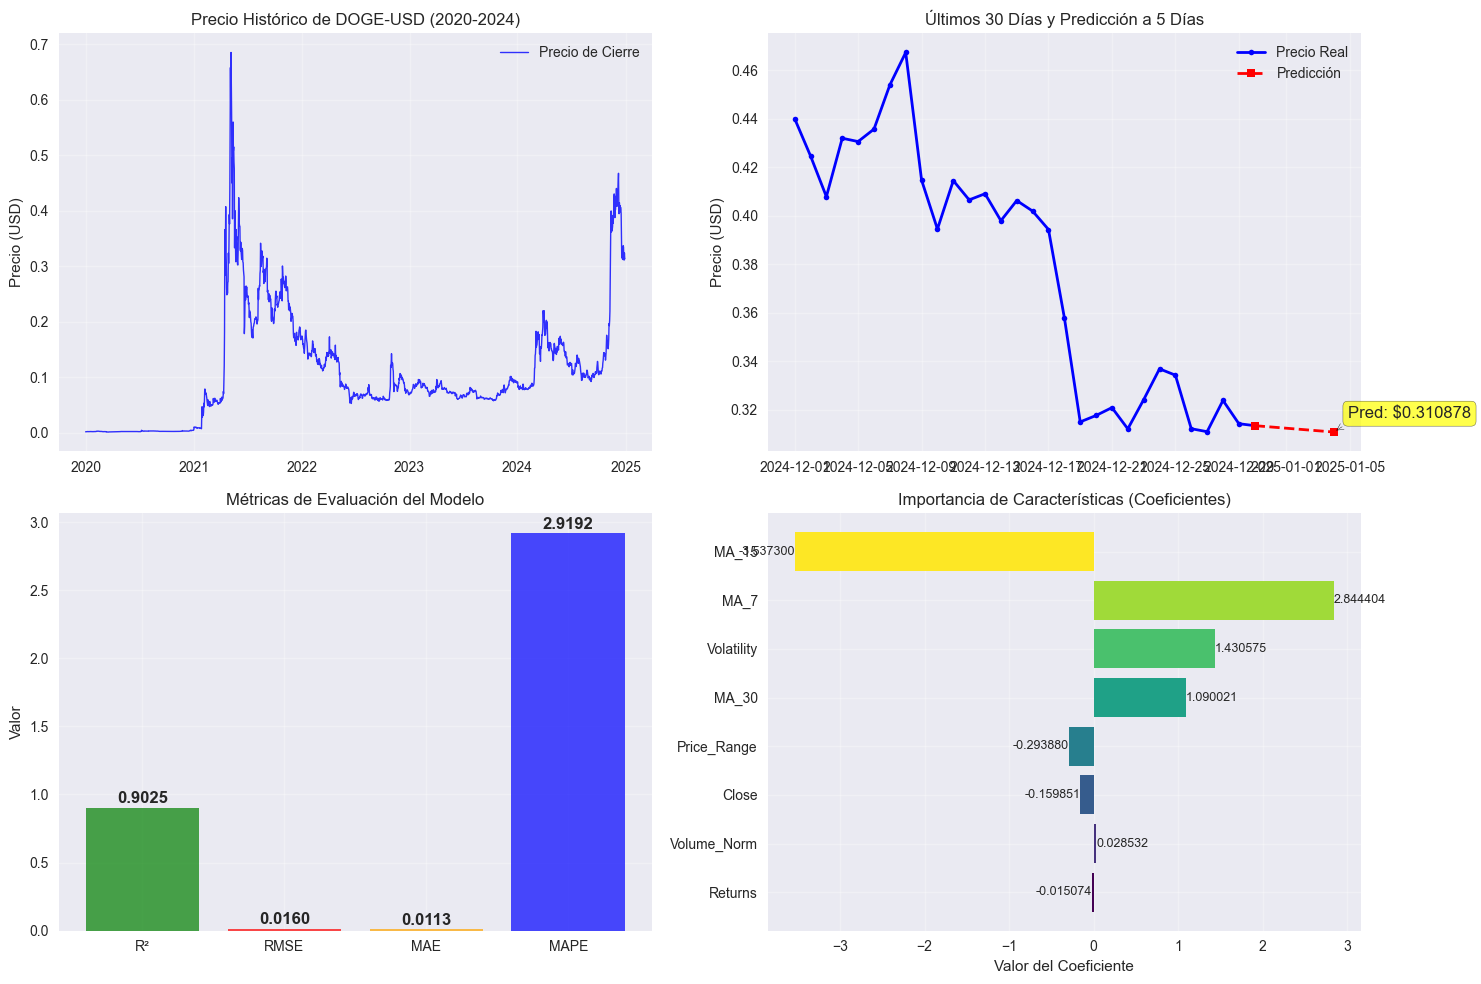

In [14]:
# Paso 9: Crear gráficos de análisis
print("📊 Creando gráficos de análisis...")

# Gráfico 1: Serie temporal completa
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df.index, df['Close'], label='Precio de Cierre', linewidth=1, color='blue', alpha=0.8)
plt.title('Precio Histórico de DOGE-USD (2020-2024)')
plt.ylabel('Precio (USD)')
plt.grid(True, alpha=0.3)
plt.legend()

# Gráfico 2: Últimos 30 días con predicción (CORREGIDO)
plt.subplot(2, 2, 2)
last_30_actual = df['Close'].tail(30)
future_dates = pd.date_range(start=df.index[-1], periods=6, freq='D')[1:]

# CORRECCIÓN: Crear array de precios que coincida con las fechas futuras
# Incluir el último precio conocido y la predicción para los 5 días
historical_dates = last_30_actual.index
prediction_dates = pd.date_range(start=df.index[-1], periods=6, freq='D')  # Incluye la última fecha

# Precios: último precio histórico + predicción para 5 días futuros
historical_prices = last_30_actual.values
predicted_prices = [last_close, prediction_value]  # Solo 2 puntos: actual y predicción final

# Graficar histórico
plt.plot(historical_dates, historical_prices, 'b-', label='Precio Real', 
         linewidth=2, marker='o', markersize=4)

# Graficar predicción - solo la línea que conecta el último punto con la predicción
plt.plot([historical_dates[-1], future_dates[-1]], 
         [last_close, prediction_value], 
         'r--', marker='s', label='Predicción', linewidth=2, markersize=6)

plt.title('Últimos 30 Días y Predicción a 5 Días')
plt.ylabel('Precio (USD)')
plt.grid(True, alpha=0.3)
plt.legend()

# Añadir anotación con el valor predicho
plt.annotate(f'Pred: ${prediction_value:.6f}', 
             xy=(future_dates[-1], prediction_value),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.7),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

# Gráfico 3: Métricas de error del modelo
plt.subplot(2, 2, 3)
metrics = ['R²', 'RMSE', 'MAE', 'MAPE']
values = [r2, rmse, mae, mape]
colors = ['green', 'red', 'orange', 'blue']

bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title('Métricas de Evaluación del Modelo')
plt.ylabel('Valor')
plt.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 4: Importancia de características
plt.subplot(2, 2, 4)
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=True)

bars = plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], 
                color=plt.cm.viridis(np.linspace(0, 1, len(features))))
plt.title('Importancia de Características (Coeficientes)')
plt.xlabel('Valor del Coeficiente')
plt.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, coef in zip(bars, feature_importance['Coefficient']):
    width = bar.get_width()
    plt.text(width + (0.0001 if width > 0 else -0.0003), bar.get_y() + bar.get_height()/2.,
             f'{coef:.6f}', ha='left' if width > 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.show()

📊 Creando predicciones diarias interpoladas...


Text(10, 10, 'Pred Día 5: $0.310878')

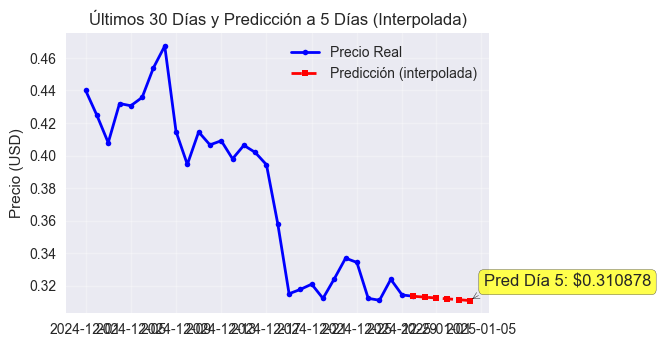

In [15]:
# Alternativa: Crear predicciones diarias (interpolación lineal)
print("📊 Creando predicciones diarias interpoladas...")

# Crear predicciones para cada día (interpolación lineal entre actual y predicción a 5 días)
daily_dates = pd.date_range(start=df.index[-1], periods=6, freq='D')
daily_predictions = np.linspace(last_close, prediction_value, 6)

plt.subplot(2, 2, 2)
# Graficar histórico
plt.plot(historical_dates, historical_prices, 'b-', label='Precio Real', 
         linewidth=2, marker='o', markersize=4)

# Graficar predicciones diarias
plt.plot(daily_dates, daily_predictions, 'r--', marker='s', 
         label='Predicción (interpolada)', linewidth=2, markersize=4)

plt.title('Últimos 30 Días y Predicción a 5 Días (Interpolada)')
plt.ylabel('Precio (USD)')
plt.grid(True, alpha=0.3)
plt.legend()

# Añadir anotación
plt.annotate(f'Pred Día 5: ${prediction_value:.6f}', 
             xy=(daily_dates[-1], prediction_value),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.7),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

In [16]:
# Paso 10: Mostrar resultados detallados (CORREGIDO)
print("\n" + "="*60)
print("📋 RESULTADOS DETALLADOS DEL MODELO")
print("="*60)

print(f"\n📊 MÉTRICAS DE EVALUACIÓN:")
print(f"   R² Score: {r2:.4f}")
print(f"   RMSE: {rmse:.6f}")
print(f"   MAE: {mae:.6f}")
print(f"   MAPE: {mape:.2f}%")
print(f"   Intercepto: {model.intercept_:.6f}")

print(f"\n🔍 COEFICIENTES DEL MODELO:")
for feature, coef in zip(features, model.coef_):
    print(f"   {feature:15}: {coef:12.6f}")

print(f"\n🎯 PREDICCIÓN:")
print(f"   Fecha última observación: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"   Precio actual: ${last_close:.6f}")
print(f"   Predicción 5 días: ${prediction_value:.6f}")
print(f"   Cambio estimado: {((prediction_value/last_close)-1)*100:+.2f}%")

print(f"\n📈 INTERPRETACIÓN MAPE:")
if mape < 5:
    print("   ✅ EXCELENTE - MAPE < 5% (Precisión muy alta)")
elif mape < 10:
    print("   ✅ BUENO - MAPE < 10% (Precisión buena)")
elif mape < 20:
    print("   ⚠️  ACEPTABLE - MAPE < 20% (Precisión moderada)")
else:
    print("   ❌ BAJA PRECISIÓN - MAPE ≥ 20%")

print(f"\n💡 El MAPE de {mape:.2f}% indica que el error promedio de las predicciones")
print(f"   es del {mape:.2f}% respecto a los valores reales.")



📋 RESULTADOS DETALLADOS DEL MODELO

📊 MÉTRICAS DE EVALUACIÓN:
   R² Score: 0.9025
   RMSE: 0.015966
   MAE: 0.011271
   MAPE: 2.92%
   Intercepto: 0.232575

🔍 COEFICIENTES DEL MODELO:
   Close          :    -0.159851
   Returns        :    -0.015074
   MA_7           :     2.844404
   MA_15          :    -3.537300
   MA_30          :     1.090021
   Volatility     :     1.430575
   Price_Range    :    -0.293880
   Volume_Norm    :     0.028532

🎯 PREDICCIÓN:
   Fecha última observación: 2024-12-30
   Precio actual: $0.313514
   Predicción 5 días: $0.310878
   Cambio estimado: -0.84%

📈 INTERPRETACIÓN MAPE:
   ✅ EXCELENTE - MAPE < 5% (Precisión muy alta)

💡 El MAPE de 2.92% indica que el error promedio de las predicciones
   es del 2.92% respecto a los valores reales.



📊 Creando gráfico adicional: Predicción vs Valores Reales...


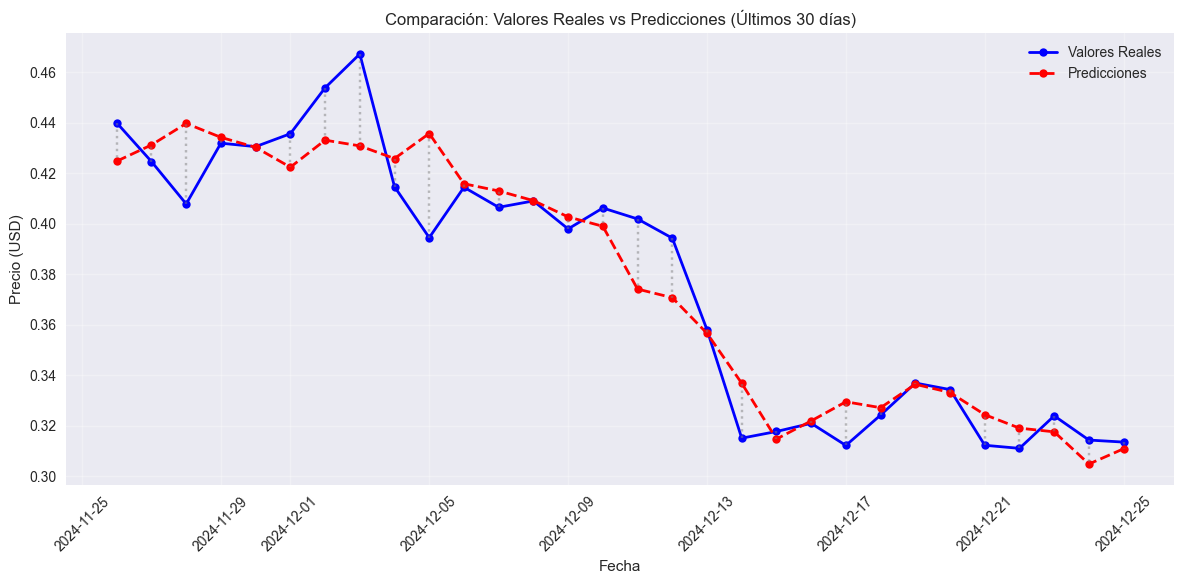

✅ Análisis completado exitosamente!


In [17]:
# Paso 11: Gráfico adicional - Predicción vs Real
print("\n📊 Creando gráfico adicional: Predicción vs Valores Reales...")

plt.figure(figsize=(12, 6))
plt.plot(last_30_days.index, y.values, 'bo-', label='Valores Reales', linewidth=2, markersize=6)
plt.plot(last_30_days.index, y_pred, 'ro--', label='Predicciones', linewidth=2, markersize=6)

# Conectar puntos reales y predichos
for i, (real, pred) in enumerate(zip(y.values, y_pred)):
    plt.plot([last_30_days.index[i], last_30_days.index[i]], [real, pred], 
             'gray', linestyle=':', alpha=0.5)

plt.title('Comparación: Valores Reales vs Predicciones (Últimos 30 días)')
plt.ylabel('Precio (USD)')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✅ Análisis completado exitosamente!")

In [18]:
# Paso 1: Importar librerías necesarias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Paso 2: Configurar estilo de gráficos
print("🔧 Configurando estilo de gráficos...")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

🔧 Configurando estilo de gráficos...


In [20]:
# Paso 3: Descargar datos de DOGE-USD
print("📥 Descargando datos de DOGE-USD...")
df = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31")
print(f"✅ Datos descargados: {len(df)} observaciones")

[*********************100%***********************]  1 of 1 completed

📥 Descargando datos de DOGE-USD...
✅ Datos descargados: 1826 observaciones


In [21]:
# Paso 4: Función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [22]:
# Paso 5: Crear características técnicas
print("🛠️ Creando características técnicas...")
def create_features(df, window_size=30, forecast_horizon=5):
    df_features = df.copy()
    df_features['Close'] = df['Close']
    df_features['Returns'] = df['Close'].pct_change()
    df_features['MA_7'] = df['Close'].rolling(window=7).mean()
    df_features['MA_15'] = df['Close'].rolling(window=15).mean()
    df_features['MA_30'] = df['Close'].rolling(window=30).mean()
    df_features['Volatility'] = df['Close'].rolling(window=window_size).std()
    df_features['Price_Range'] = df['High'] - df['Low']
    df_features['Volume_Norm'] = df['Volume'] / df['Volume'].rolling(window=30).mean()
    df_features['Target_5d'] = df['Close'].shift(-forecast_horizon)
    return df_features.dropna()

df_features = create_features(df)

🛠️ Creando características técnicas...


In [23]:
# Paso 6: Seleccionar datos para entrenamiento
print("📊 Seleccionando últimos 30 días para entrenamiento...")
last_30_days = df_features.tail(30)
features = ['Close', 'Returns', 'MA_7', 'MA_15', 'MA_30', 'Volatility', 'Price_Range', 'Volume_Norm']
X = last_30_days[features]
y = last_30_days['Target_5d']

📊 Seleccionando últimos 30 días para entrenamiento...


In [24]:
# Paso 7: Entrenar el modelo
print("🤖 Entrenando modelo de regresión lineal...")
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calcular métricas
mape = mean_absolute_percentage_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)


🤖 Entrenando modelo de regresión lineal...


In [25]:
# Paso 8: Hacer predicción para 5 días
print("🔮 Haciendo predicción para 5 días futuros...")
last_observation = df_features.tail(1)[features]
prediction_5d = model.predict(last_observation)
prediction_value = float(prediction_5d[0])
last_close = float(df['Close'].iloc[-1])

print(f"📈 Último precio: ${last_close:.6f}")
print(f"🎯 Predicción 5 días: ${prediction_value:.6f}")

🔮 Haciendo predicción para 5 días futuros...
📈 Último precio: $0.313514
🎯 Predicción 5 días: $0.310878


In [26]:
# Paso 9: Crear tabla de predicciones diarias
print("📋 Generando tabla de predicciones...")

# Fechas de los próximos 5 días
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')

# Interpolación lineal de precios para cada día
daily_predictions = np.linspace(last_close, prediction_value, 6)[1:]  # Excluir el día actual

# Calcular retornos diarios esperados
daily_returns = [(daily_predictions[i] / daily_predictions[i-1] - 1) * 100 if i > 0 else 
                (daily_predictions[i] / last_close - 1) * 100 for i in range(len(daily_predictions))]

# Crear tabla de predicciones
prediction_table = pd.DataFrame({
    'Fecha': future_dates,
    'Día': [f'Día {i+1}' for i in range(5)],
    'Precio_Predicho': daily_predictions,
    'Retorno_Esperado_%': daily_returns
})

# Añadir sugerencias de inversión basadas en retornos esperados
def get_investment_suggestion(return_percent):
    if return_percent > 2.0:
        return "🚀 COMPRAR FUERTE - Alto potencial"
    elif return_percent > 0.5:
        return "✅ COMPRAR - Buen potencial"
    elif return_percent > -0.5:
        return "⚪ MANTENER - Neutral"
    elif return_percent > -2.0:
        return "⚠️  CAUTELA - Posible baja"
    else:
        return "🔴 VENDER - Tendencia bajista"

prediction_table['Sugerencia'] = prediction_table['Retorno_Esperado_%'].apply(get_investment_suggestion)

# Calcular estadísticas adicionales
total_return = ((prediction_value / last_close) - 1) * 100
avg_daily_return = prediction_table['Retorno_Esperado_%'].mean()


📋 Generando tabla de predicciones...


In [33]:
# Paso 10: Mostrar tabla de predicciones
print("\n" + "="*100)
print("📊 TABLA DE PREDICCIÓN - DOGE-USD (Próximos 5 días)")
print("="*100)
print(prediction_table.to_string(index=False, formatters={
    'Precio_Predicho': lambda x: f'${x:.7f}',
    'Retorno_Esperado_%': lambda x: f'{x:+.2f}%'
}))
print("="*100)

# Resumen de la predicción
print(f"\n📈 RESUMEN DE LA PREDICCIÓN:")
print(f"   Precio inicial: ${last_close:.6f}")
print(f"   Precio final predicho: ${prediction_value:.4f}")
print(f"   Retorno total esperado: {total_return:+.2f}%")
print(f"   Retorno diario promedio: {avg_daily_return:+.2f}%")
print(f"   Mejor día: Día {prediction_table['Retorno_Esperado_%'].idxmax() + 1}")
print(f"   Peor día: Día {prediction_table['Retorno_Esperado_%'].idxmin() + 1}")

# Paso 11: Gráfico de las predicciones
print("\n📊 Creando gráfico de predicciones...")

plt.figure(figsize=(14, 10))


📊 TABLA DE PREDICCIÓN - DOGE-USD (Próximos 5 días)
     Fecha   Día Precio_Predicho Retorno_Esperado_%           Sugerencia
2024-12-31 Día 1      $0.3129869             -0.17% ⚪ MANTENER - Neutral
2025-01-01 Día 2      $0.3124597             -0.17% ⚪ MANTENER - Neutral
2025-01-02 Día 3      $0.3119326             -0.17% ⚪ MANTENER - Neutral
2025-01-03 Día 4      $0.3114055             -0.17% ⚪ MANTENER - Neutral
2025-01-04 Día 5      $0.3108784             -0.17% ⚪ MANTENER - Neutral

📈 RESUMEN DE LA PREDICCIÓN:
   Precio inicial: $0.313514
   Precio final predicho: $0.3109
   Retorno total esperado: -0.84%
   Retorno diario promedio: -0.17%
   Mejor día: Día 1
   Peor día: Día 5

📊 Creando gráfico de predicciones...


<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

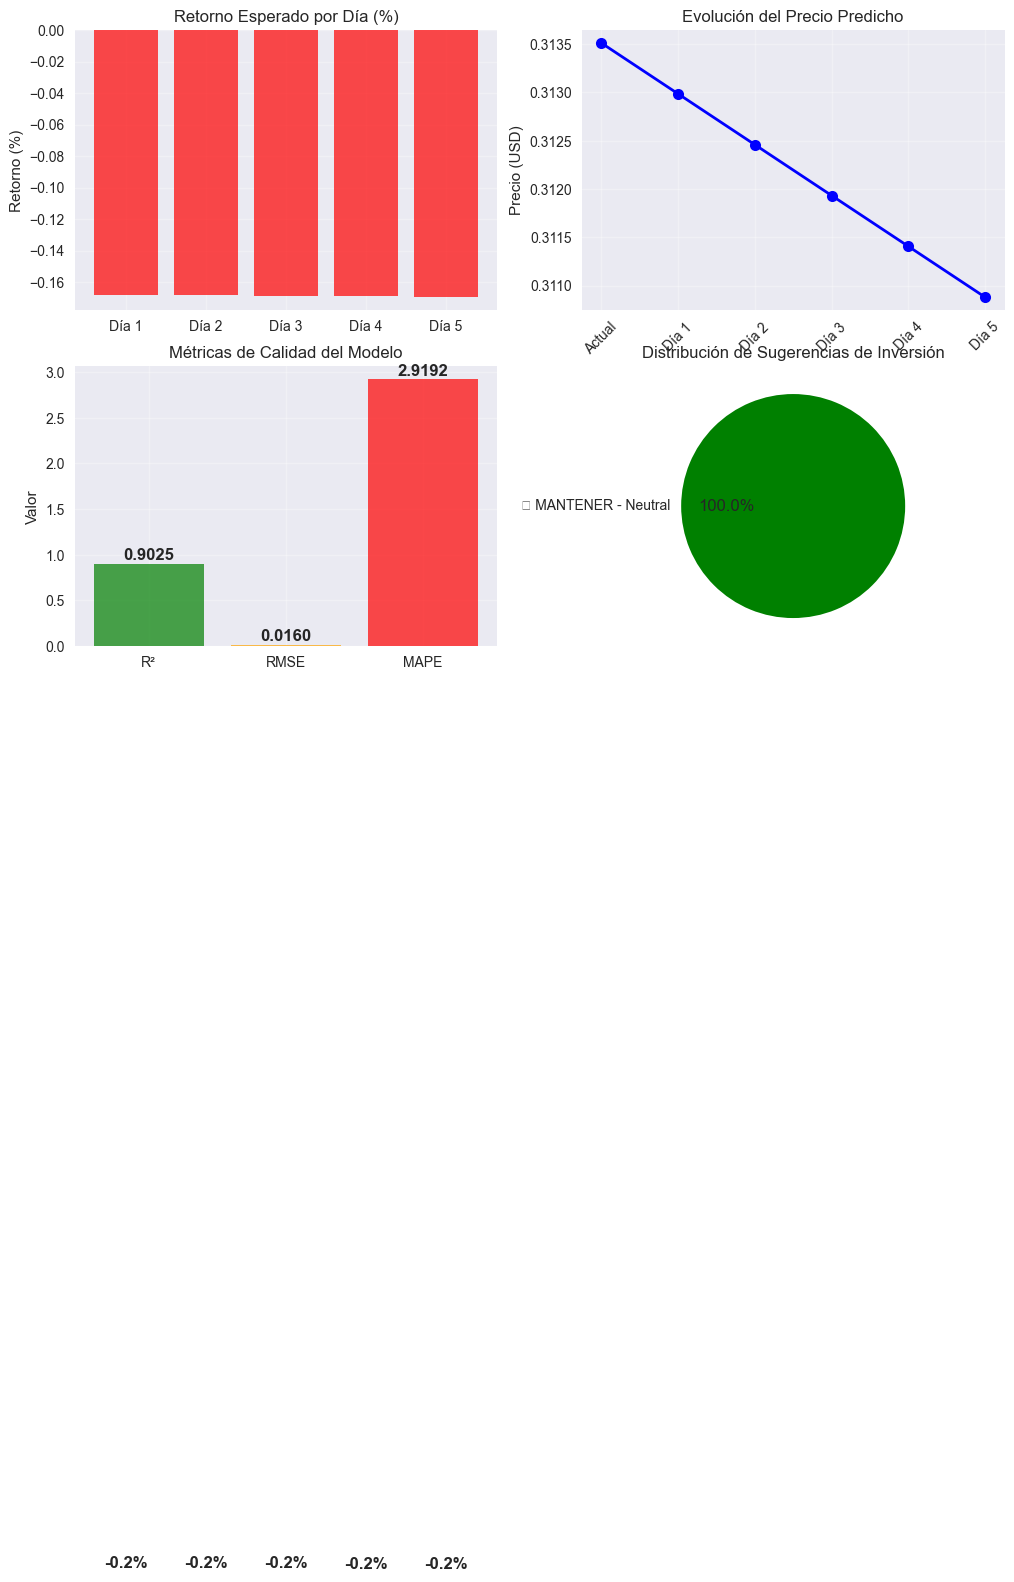

In [28]:
# Gráfico 1: Predicciones diarias
plt.subplot(2, 2, 1)
colors = ['green' if ret > 0 else 'red' for ret in prediction_table['Retorno_Esperado_%']]
bars = plt.bar(prediction_table['Día'], prediction_table['Retorno_Esperado_%'], color=colors, alpha=0.7)
plt.title('Retorno Esperado por Día (%)')
plt.ylabel('Retorno (%)')
plt.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, ret in zip(bars, prediction_table['Retorno_Esperado_%']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if ret > 0 else -0.8),
             f'{ret:+.1f}%', ha='center', va='bottom' if ret > 0 else 'top', fontweight='bold')

# Gráfico 2: Evolución del precio predicho
plt.subplot(2, 2, 2)
plt.plot(['Actual'] + prediction_table['Día'].tolist(), 
         [last_close] + prediction_table['Precio_Predicho'].tolist(), 
         'bo-', linewidth=2, markersize=8)
plt.title('Evolución del Precio Predicho')
plt.ylabel('Precio (USD)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Gráfico 3: Métricas del modelo
plt.subplot(2, 2, 3)
metrics = ['R²', 'RMSE', 'MAPE']
values = [r2, rmse, mape]
colors = ['green', 'orange', 'red']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title('Métricas de Calidad del Modelo')
plt.ylabel('Valor')
plt.grid(True, alpha=0.3)

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 4: Sugerencias de inversión por día
plt.subplot(2, 2, 4)
suggestions = prediction_table['Sugerencia'].value_counts()
plt.pie(suggestions.values, labels=suggestions.index, autopct='%1.1f%%',
        colors=['green', 'lightgreen', 'gray', 'orange', 'red'])
plt.title('Distribución de Sugerencias de Inversión')

plt.tight_layout()
plt.show()

In [29]:
# Paso 12: Recomendación final basada en la predicción
print("\n" + "="*60)
print("🎯 RECOMENDACIÓN FINAL DE INVERSIÓN")
print("="*60)

if total_return > 5:
    print("🚀 RECOMENDACIÓN: COMPRAR")
    print("   La predicción indica una tendencia alcista fuerte")
    print("   Buen momento para entrar en la posición")
elif total_return > 0:
    print("✅ RECOMENDACIÓN: CONSIDERAR COMPRA")
    print("   Tendencia moderadamente alcista")
    print("   Podría ser buen momento para invertir")
elif total_return > -2:
    print("⚪ RECOMENDACIÓN: ESPERAR")
    print("   Mercado lateral o con poca tendencia")
    print("   Mejor esperar señales más claras")
else:
    print("🔴 RECOMENDACIÓN: NO COMPRAR")
    print("   Tendencia bajista predicha")
    print("   Considerar esperar o buscar otras oportunidades")

print(f"\n💡 Basado en un retorno total esperado de: {total_return:+.2f}%")
print(f"📅 Período de la predicción: {future_dates[0].strftime('%Y-%m-%d')} al {future_dates[-1].strftime('%Y-%m-%d')}")


🎯 RECOMENDACIÓN FINAL DE INVERSIÓN
⚪ RECOMENDACIÓN: ESPERAR
   Mercado lateral o con poca tendencia
   Mejor esperar señales más claras

💡 Basado en un retorno total esperado de: -0.84%
📅 Período de la predicción: 2024-12-31 al 2025-01-04


In [30]:
# Paso 13: Advertencias y limitaciones
print("\n" + "="*60)
print("⚠️  ADVERTENCIAS Y LIMITACIONES")
print("="*60)
print("• Las criptomonedas son altamente volátiles")
print("• Las predicciones tienen margen de error")
print("• Este no es consejo financiero profesional")
print("• Siempre haz tu propia investigación")
print("• Considera el riesgo antes de invertir")
print(f"• MAPE del modelo: {mape:.2f}% (Error promedio)")

print("\n✅ Análisis completado exitosamente!")


⚠️  ADVERTENCIAS Y LIMITACIONES
• Las criptomonedas son altamente volátiles
• Las predicciones tienen margen de error
• Este no es consejo financiero profesional
• Siempre haz tu propia investigación
• Considera el riesgo antes de invertir
• MAPE del modelo: 2.92% (Error promedio)

✅ Análisis completado exitosamente!
